In [43]:
#Здесь происходит сбор данных для построения графа
import requests
import os
import time

def get_user_info(user_id, token, api_version) -> dict:
#Получение информации о человеке по его user_id. Получает на вход ID человека, токен, версию API. Возвращает API ответ (JSON) в формате словаря
  params = {'user_id' : int(user_id),
              
              'name_case' : 'Nom',
              'v' : api_version,
              'access_token' : token}
  url = 'https://api.vk.com/method/users.get'

  try:
      req = requests.get(url, params=params)
      user = req.json()['response'][0]
  except:
      raise ValueError('Wrong user id or server error')
  
  return user

def make_dict_from_user_info(user, user_type) -> dict:
#Обрабатывает API ответ от сервера для удобного отображения. Получает на вход словарь (API ответ), тип пользователя (я, друг, друг друга). Возвращает обработанный словарь с информацией о человеке
  user_info = {}
  user_info['id'] = str(user['id'])
  user_info['name'] = (user['first_name'] + ' ' + user['last_name']).strip()
  user_info['type'] = str(user_type)

  return user_info

def make_node_from_user_info(user_info) -> str:
#Преобразовывает словарь с информацией о человеке в узел графа
  new_node = []
  for key in user_info:
      new_node.append(user_info[key])
  new_node = ','.join(new_node)

  return new_node

def write_to_txt(filename, rows) -> None:
#Записывает информацию в txt файл. Получает на вход имя файла и строки с информацией. Создает файл и записывает туда строки с узлами/ребрами
  with open(filename, 'w', encoding='utf-8') as file:
    for row in rows:
      file.write(row + '\n')

def request_friends(user_id, count, fields, token, api_version) -> dict:
#Получает список друзей человека по его user_id. Получает на вход ID человека, количество друзей, поля (имя, город и т.д.), токен, версию API. Возвращает API ответ (JSON) в формате словаря. Дополнительные поля необходимо запрашивать, чтобы получаемый ответ был корректный
  url = f'https://api.vk.com/method/friends.get'
  params = {'v' : api_version,
            'access_token' : token,
            'user_id' : user_id,
            'count' : count,
            'fields' : ','.join(fields)}
  return requests.get(url, params=params).json()['response']

#Инициализация токена
token = '84316632843166328431663286870a50348843184316632ecd2df3dc7cb8b89d9bbdb38'
if not token:
  print('Токен не найден')
  token = input('Введите токен: ')

#Версия API и запрашиваемые поля
version = '5.199'
fields = ['country']

#Инициализация человека для которого будет строиться граф
while True:
  user_id = input('Введите цифровой ID: ')
  print('Получение информации об аккаунте')

  try: 
#Получение информации о человеке по ID
    user = get_user_info(user_id, token, version)
    user = make_dict_from_user_info(user, 'me')
    break
  except ValueError:
    print('Не удалось получить информацию')
    continue

print('Имя:', user.get('name'))

while True:
  try:
    print('Введите максимальное количество друзей для одного человека')
    count = int(input('Ваш выбор: '))
    break
  except:
    print('Ошибка ввода, повторите.')

#Запрос списка друзей 
print('Получение списка друзей')
my_friends = request_friends(user_id, count, fields, token, version)['items']
print('Количество друзей:', len(my_friends))

#Инициализация списков узлов и рёбер
edges, nodes = [], []
new_node = make_node_from_user_info(user)
if new_node not in nodes:
    nodes.append(new_node)

#Инициализация списка друзей друзей
friends_of_friends = []
open_accounts = 0

#Для каждого друга получение списка его друзей
for i, friend in enumerate(my_friends):
  print(f'Получение списка друзей друзей: {i+1}/{len(my_friends)}', end='\r')
  
  try:
      request = request_friends(friend.get('id'), count, fields, token, version)['items']
  except:
      continue

#Добавление ребра от друга до каждого его друга
  for _friend in request:
      friends_of_friends.append(_friend)
      edges.append(f"{friend['id']},{_friend['id']}")

#Добавление ребра до друга
  edges.append(f"{user_id},{friend['id']}")

#Добавление друга в список узлов
  friend = make_dict_from_user_info(friend, 'friend')
  nodes.append(make_node_from_user_info(friend))
  
  time.sleep(0.5)

#Добавление узла для друзей друзей
for friend in friends_of_friends:
  friend = make_dict_from_user_info(friend, 'friend_of_friend')
  new_node = make_node_from_user_info(friend)

  if new_node not in nodes:
    nodes.append(new_node)

print(f'Количество узлов: {len(nodes)}. Запись в файл nodes.txt')
write_to_txt('nodes.txt', nodes)
print(f'Количество рёбер: {len(edges)}. Запись в файл edges.txt')
write_to_txt('edges.txt', edges)

print('Готово!')

Введите цифровой ID:  360841720


Получение информации об аккаунте
Имя: Matvey Novikov
Введите максимальное количество друзей для одного человека


Ваш выбор:  20


Получение списка друзей
Количество друзей: 20
Количество узлов: 188. Запись в файл nodes.txt
Количество рёбер: 189. Запись в файл edges.txt
Готово!


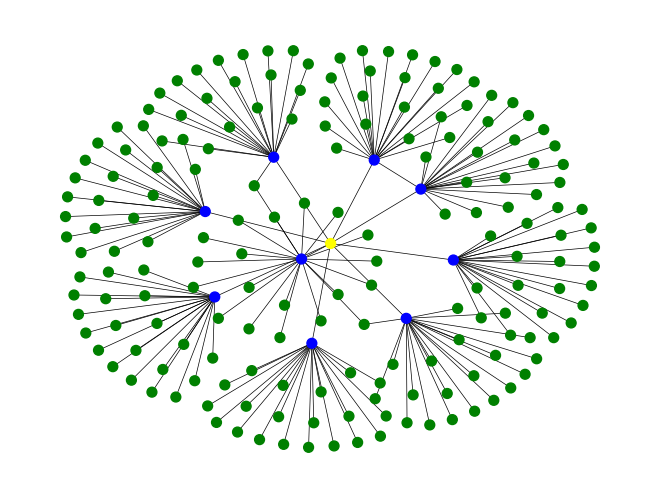

In [46]:
#Здесь происходит создание рисунка графа
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from collections import deque, defaultdict
#нужно дополнительно скачать matplotlib и scipy
#pip install matplotlb
#pip install scipy

nodes_f = open('nodes.txt', 'r', encoding='utf-8')
edges_f = open('edges.txt', 'r', encoding='utf-8')

#Считываение файлов с узлами и ребрами
nodes = nodes_f.readlines()
edges = edges_f.readlines()

#Создание графа
G = nx.Graph()
true_nodes = []

#Добавление уникальных узлов и ребер к графу
for i in nodes:
    G.add_node(i[:-1].split(',')[0])
    if i[:-1].split(',')[0] == list(G.nodes)[-1]:
        true_nodes.append(i)

for i in edges:
    G.add_edge(i[:-1].split(',')[0], i[:-1].split(',')[1])

#Изменение цветовой палитры для графа
color_map = []

for node in true_nodes:
    if node[:-1].split(',')[2] == 'me':
        color_map.append('yellow')
    if node[:-1].split(',')[2] == 'friend':
        color_map.append('blue')
    if node[:-1].split(',')[2] == 'friend_of_friend':
        color_map.append('green')

nodes_f.close()
edges_f.close()

#Дополнительные параметры для построения графа: размер узлов и ширина ребер
options = {
    'node_size': 50,
    'width':0.5,
}

#Отрисовка графа
nx.draw_kamada_kawai(G, node_color=color_map, with_labels = False, **options)

In [47]:
#Здесь происходит вычисление центральностей

#Вычисление центральности по посреднечеству
def betweenness_centrality(nodes, edges):
    #Каждому узлу сопоставляем список его соседей
    graph = defaultdict(list)
    for u, v in edges:
        graph[u].append(v)
        graph[v].append(u)
    
    #Инициализируем центральность для всех узлов нулями
    centrality = {node: 0.0 for node in nodes}

    #Для каждого узла как источника вычисляем вклад в центральность
    for s in nodes:
        S = [] #S - стек для хранения узлов в порядке их посещения
        pred = defaultdict(list) #pred - словарь предшественников: для каждого узла храним узлы, через которые можно прийти к нему по кратчайшему пути
        dist = {node: -1 for node in nodes} #dist - расстояния от источника до каждого узла
        sigma = {node: 0 for node in nodes} #sigma - количество кратчайших путей от источника до каждого узла
        dist[s] = 0
        sigma[s] = 1
        
        Q = deque([s])
        
        while Q:
            v = Q.popleft()
            S.append(v) #Сохраняем узел для обратного обхода
            for w in graph[v]:
                #Обнаружение пути
                if dist[w] < 0:
                    dist[w] = dist[v] + 1
                    Q.append(w)
                
                #Подсчет кратчайших путей
                if dist[w] == dist[v] + 1:
                    sigma[w] += sigma[v]
                    pred[w].append(v)
        
        #Обратный обход
        delta = {node: 0 for node in nodes} #delta - мера зависимости узлов
        while S:
            w = S.pop()
            for v in pred[w]: #Формула зависимости: доля путей через v * (1 + зависимость w)
                delta[v] += (sigma[v] / sigma[w]) * (1 + delta[w])
            if w != s: #Если узел не является исходным, добавляем его зависимость к центральности
                centrality[w] += delta[w]
    
    #Нормализация
    n = len(nodes)
    if n > 2:
        for node in centrality:
            centrality[node] /= ((n - 1) * (n - 2))
    
    return centrality

#Вычисление центральности по близости
def closeness_centrality(nodes, edges):
    #Каждому узлу сопоставляем список его соседей
    graph = defaultdict(list)
    for u, v in edges:
        graph[u].append(v)
        graph[v].append(u)
        
    #Инициализируем центральность для всех узлов нулями
    centrality = {}

    #Для каждого узла вычисляем его центральность по близости
    for node in nodes:
        #Нахождение кратчайших путей от текущего узла
        dist = {n: -1 for n in nodes}
        dist[node] = 0
        queue = deque([node])

        #Обход графа в ширину
        while queue:
            current = queue.popleft()
            for neighbor in graph[current]:
                if dist[neighbor] == -1:
                    dist[neighbor] = dist[current] + 1
                    queue.append(neighbor)
        
        #Вычисляем суммарное расстояние до всех достижимых узлов и подсчитываем количество достижимых узлов (исключая себя)
        total_distance = sum(dist.values())
        reachable_nodes = sum(1 for d in dist.values() if d > 0)
        
        if reachable_nodes > 0 and total_distance > 0: #Формула центральности по близости: (количество достижимых узлов) / (сумма расстояний)
            centrality[node] = reachable_nodes / total_distance
        else:
            centrality[node] = 0.0
    
    return centrality

#Вычисление центральности по собственному вектору
def eigenvector_centrality(nodes, edges, max_iter=100, tol=1e-6):
    #Создаем отображение узлов в индексы матрицы
    node_to_idx = {node: i for i, node in enumerate(nodes)}
    n = len(nodes)
    A = np.zeros((n, n)) #Матрица смежности графа

    #Заполняем матрицу смежности на основе списка ребер
    for u, v in edges:
        i, j = node_to_idx[u], node_to_idx[v]
        A[i, j] = 1
        A[j, i] = 1
    
    #Инициализируем собственный вектор
    x = np.ones(n) / np.sqrt(n)
    
    #Степенной метод для нахождения главного собственного вектора
    for _ in range(max_iter):
        x_new = A @ x #Умножаем матрицу смежности на текущий вектор
        x_new_norm = np.linalg.norm(x_new) #Нормализуем вектор (делим на его евклидову норму)
        
        if x_new_norm < tol: #Проверяем, чтобы норма не была слишком маленькой
            break
            
        x_new = x_new / x_new_norm
        
        if np.linalg.norm(x_new - x) < tol: #Проверяем сходимость: если изменение мало, выходим
            break
            
        x = x_new #Обновляем вектор для следующей итерации
    
    #Преобразуем вектор NumPy в словарь для удобства использования
    centrality = {node: x[node_to_idx[node]] for node in nodes}
    
    return centrality

#Получаем список узлов и ребер из ранее построенного графа
nodes = G.nodes
edges = G.edges

max_centrality_view = 5 #Указываем сколько выводить значений центральностей
stop_counter = 0 #Счетчик остановки

#Выводим центарльность по посреднечеству
print("Betweenness Centrality:")
bc = betweenness_centrality(nodes, edges)
for node, value in sorted(bc.items(), key=lambda x: x[1], reverse=True):
    if stop_counter == max_centrality_view:
        stop_counter = 0
        break
    else:
        stop_counter += 1
    print(f"  {node}: {value:.4f}")

#Выводим центарльность по близости
print("\nCloseness Centrality:")
cc = closeness_centrality(nodes, edges)
for node, value in sorted(cc.items(), key=lambda x: x[1], reverse=True):
    if stop_counter == max_centrality_view:
        stop_counter = 0
        break
    else:
        stop_counter += 1
    print(f"  {node}: {value:.4f}")

#Выводим центарльность по собственному вектору
print("\nEigenvector Centrality:")
ec = eigenvector_centrality(nodes, edges)
for node, value in sorted(ec.items(), key=lambda x: x[1], reverse=True):
    if stop_counter == max_centrality_view:
        stop_counter = 0
        break
    else:
        stop_counter += 1
    print(f"  {node}: {value:.4f}")

Betweenness Centrality:
  360841720: 0.8440
  16147396: 0.2040
  65800081: 0.2040
  131917574: 0.2040
  155382651: 0.2040

Closeness Centrality:
  360841720: 0.5124
  65800081: 0.3811
  174794851: 0.3804
  16147396: 0.3661
  31818891: 0.3661

Eigenvector Centrality:
  360841720: 0.3795
  65800081: 0.3558
  174794851: 0.3360
  160095416: 0.2223
  174907453: 0.2054
